In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
hm = np.zeros((200,200))

offset = 42
xc, yc = hm.shape[0] //2, hm.shape[1]//2

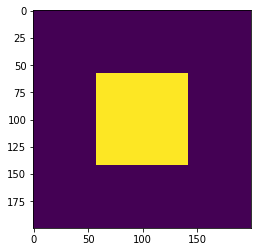

In [6]:
hm[xc - offset: xc + offset , yc - offset: yc + offset] = 255
# hm[:,65:65 + 20] = 255
plt.imshow(hm.squeeze())
plt.show()

In [7]:
cv2.imwrite('/home/francesco/Desktop/center.png', hm)

True